In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [38]:
import splitfolders 


input_folder = '/Users/admin/Downloads/DSGP/Fruit Dataset'


splitfolders.ratio(input_folder, output='/Users/admin/Downloads/DSGP/Fruit Dataset_S', 
                   seed=42, ratio=(.8, .1, .1), 
                   group_prefix=None) 

Copying files: 6600 files [00:02, 2541.87 files/s]


In [39]:
train_dataset_path = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/train'
validation_dataset_path = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/val'

In [40]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

In [41]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 5280 images belonging to 3 classes.


In [42]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 660 images belonging to 3 classes.


In [43]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Over Ripe
1 : Ripe
2 : Unripe


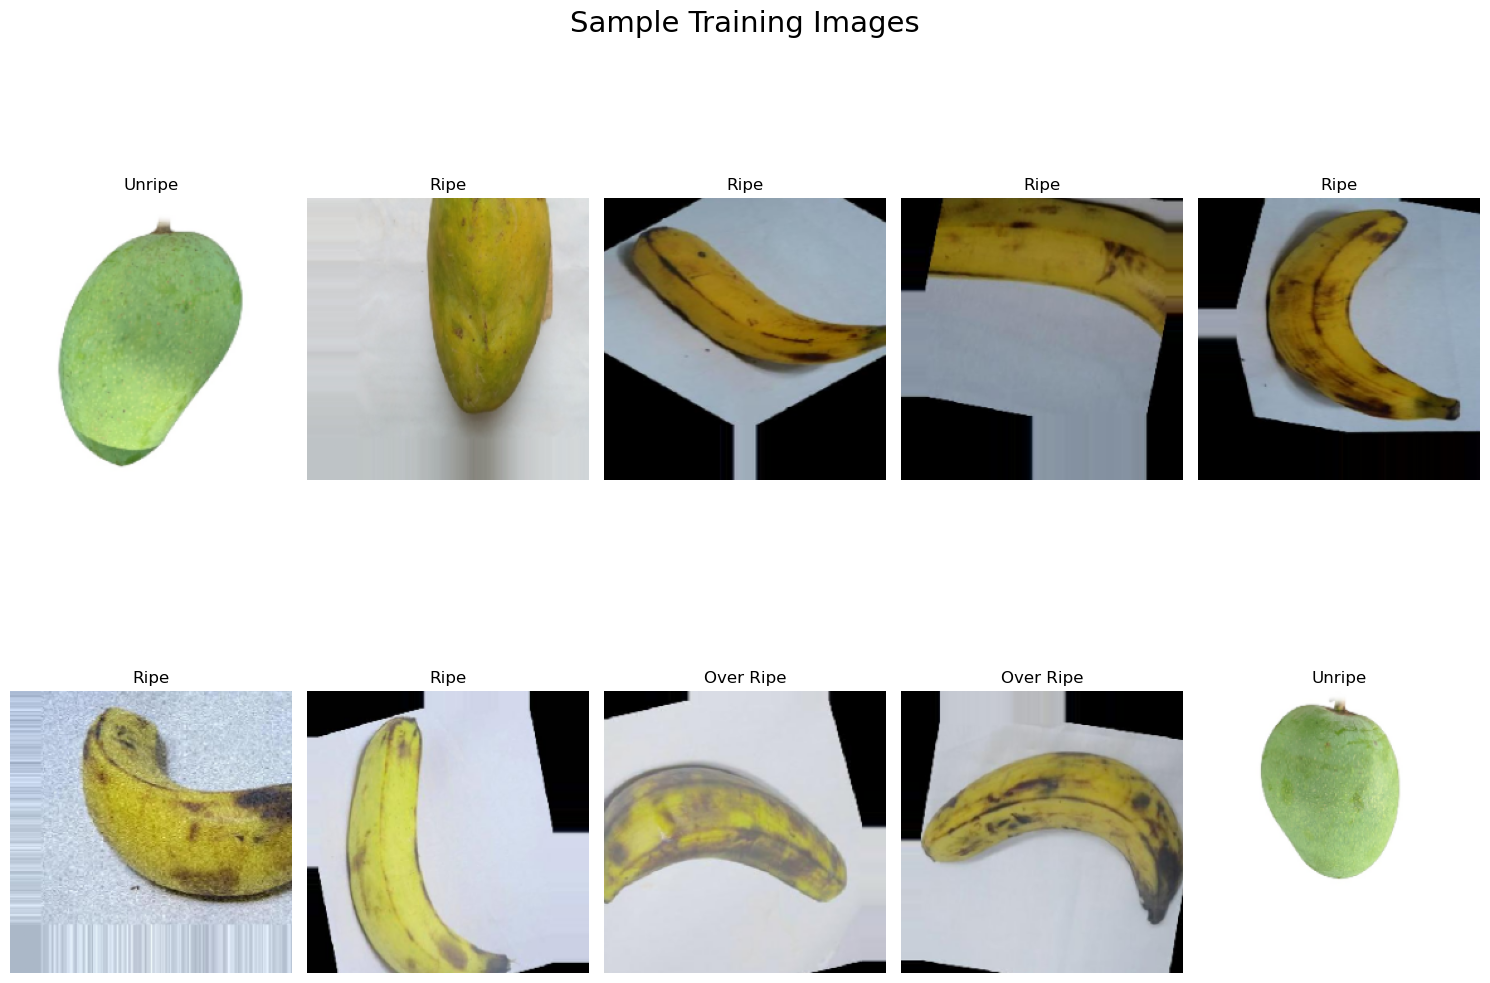

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [45]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=3, activation='softmax')
    ])
    
    return model

In [46]:
cnn_model = create_model()

In [47]:
print(cnn_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 220, 220, 128)     9728      
                                                                 
 activation_9 (Activation)   (None, 220, 220, 128)     0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 110, 110, 128)     0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Bat  (None, 110, 110, 128)     512       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 108, 108, 64)      73792     
                                                                 
 activation_10 (Activation)  (None, 108, 108, 64)     

In [48]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [49]:
optimizer = LegacyAdam(learning_rate=0.001)

In [50]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [51]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50
165/165 - 34s - loss: 8.1595 - accuracy: 0.7667 - val_loss: 7.7637 - val_accuracy: 0.6318 - lr: 0.0010 - 34s/epoch - 204ms/step
Epoch 2/50
165/165 - 33s - loss: 7.4800 - accuracy: 0.7989 - val_loss: 18.0232 - val_accuracy: 0.7030 - lr: 0.0010 - 33s/epoch - 202ms/step
Epoch 3/50
165/165 - 33s - loss: 8.3743 - accuracy: 0.7953 - val_loss: 42.1495 - val_accuracy: 0.6742 - lr: 0.0010 - 33s/epoch - 202ms/step
Epoch 4/50
165/165 - 34s - loss: 9.3956 - accuracy: 0.8009 - val_loss: 35.3456 - val_accuracy: 0.6045 - lr: 0.0010 - 34s/epoch - 203ms/step
Epoch 5/50
165/165 - 33s - loss: 10.4915 - accuracy: 0.7920 - val_loss: 388.7354 - val_accuracy: 0.3515 - lr: 0.0010 - 33s/epoch - 198ms/step
Epoch 6/50
165/165 - 33s - loss: 10.6856 - accuracy: 0.8047 - val_loss: 14.8358 - val_accuracy: 0.8030 - lr: 0.0010 - 33s/epoch - 198ms/step
Epoch 7/50
165/165 - 32s - loss: 6.5845 - accuracy: 0.8352 - val_loss: 9.9798 - val_accuracy: 0.7833 - lr: 3.1623e-04 - 32s/epoch - 194ms/step
Epoch 8/50
165/

In [54]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

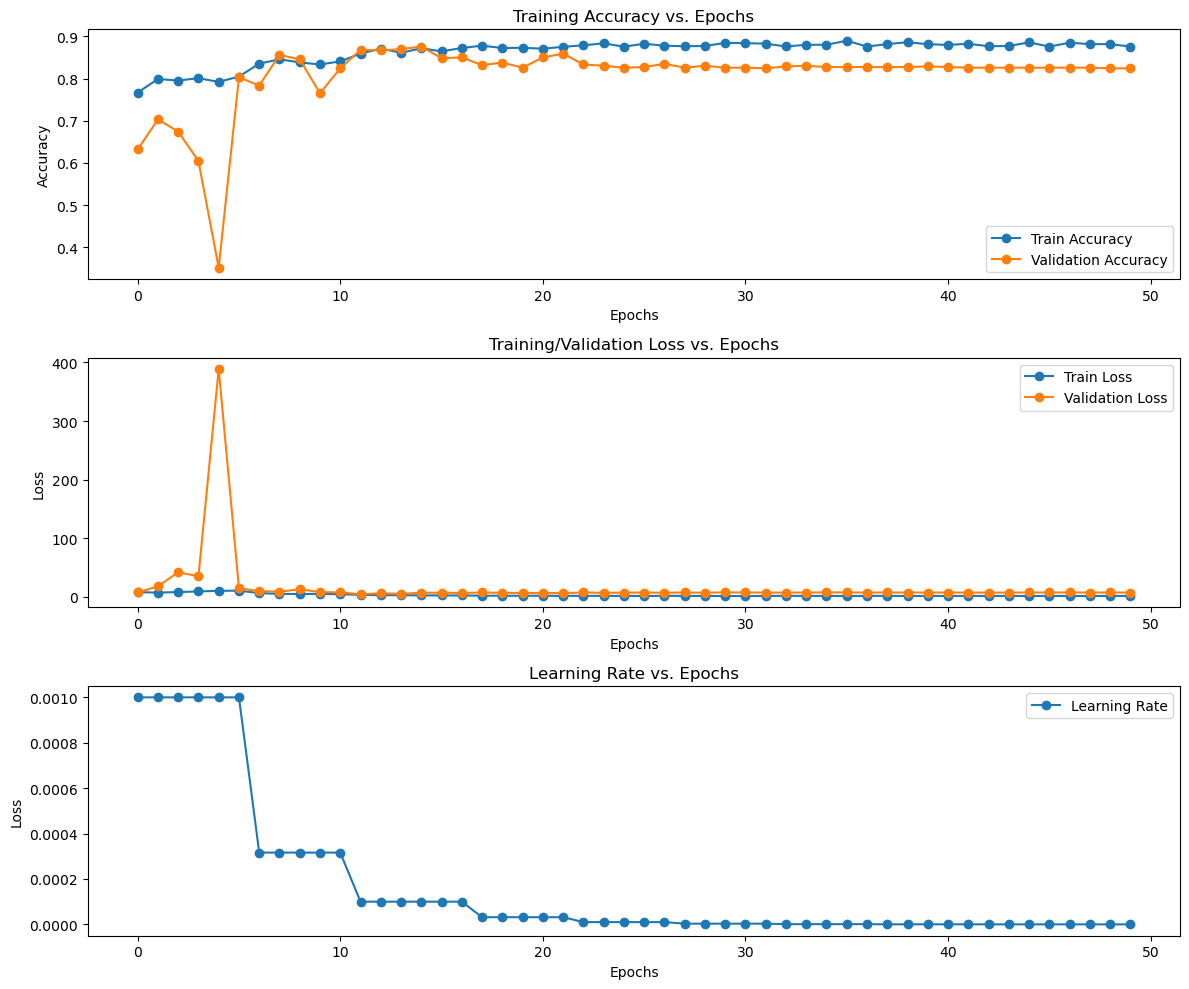

In [55]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [56]:
test_dataset = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/test'

In [57]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')


Found 660 images belonging to 3 classes.


In [58]:
predictions = cnn_model.predict(test_generator)

21/21 [==============================] - 1s 48ms/step


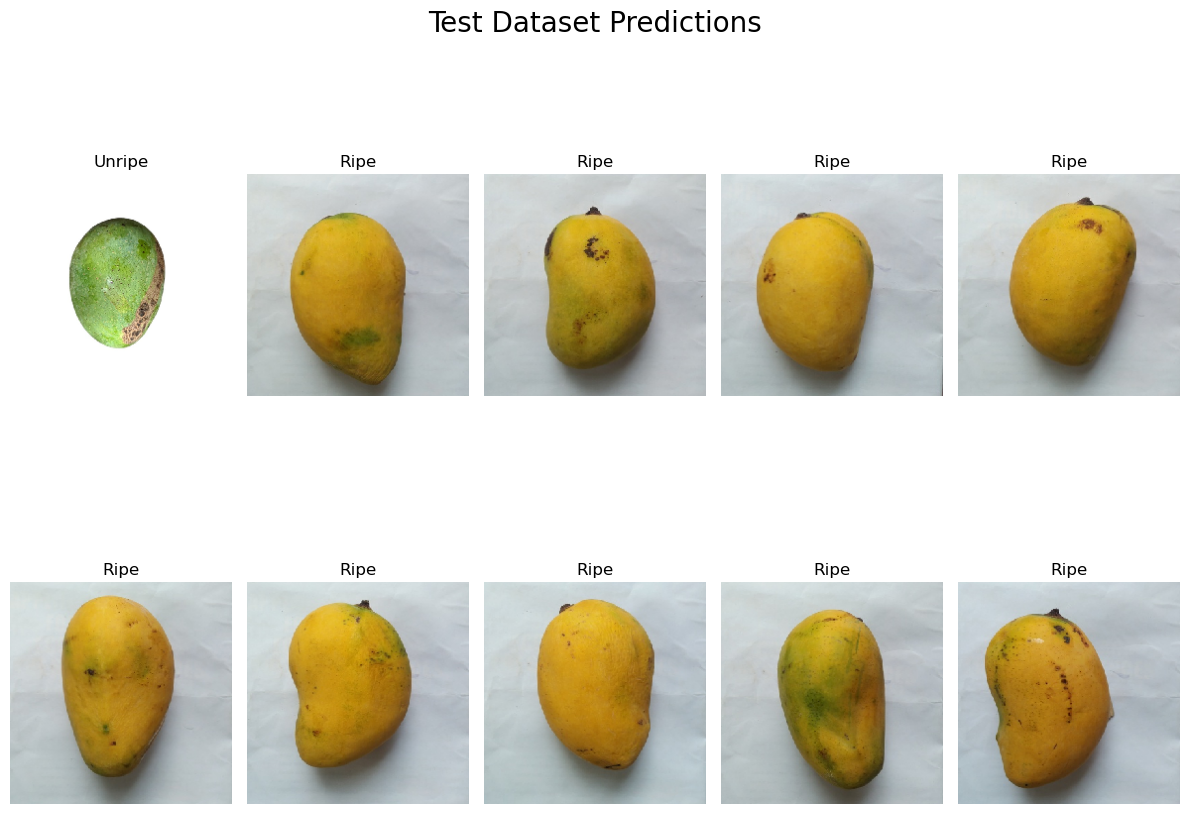

In [59]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [60]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

21/21 [==============================] - 1s 49ms/step - loss: 6.4037 - accuracy: 0.8394


In [61]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Test Loss:     6.403724193572998
Test Accuracy: 0.8393939137458801


In [62]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

<Axes: >

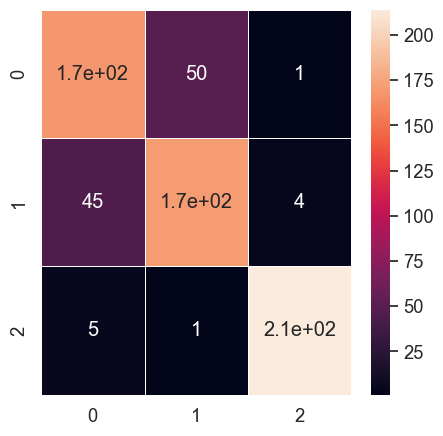

In [69]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


In [70]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   Over Ripe       0.77      0.77      0.77       220
        Ripe       0.77      0.78      0.77       220
      Unripe       0.98      0.97      0.97       220

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660



In [71]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [72]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

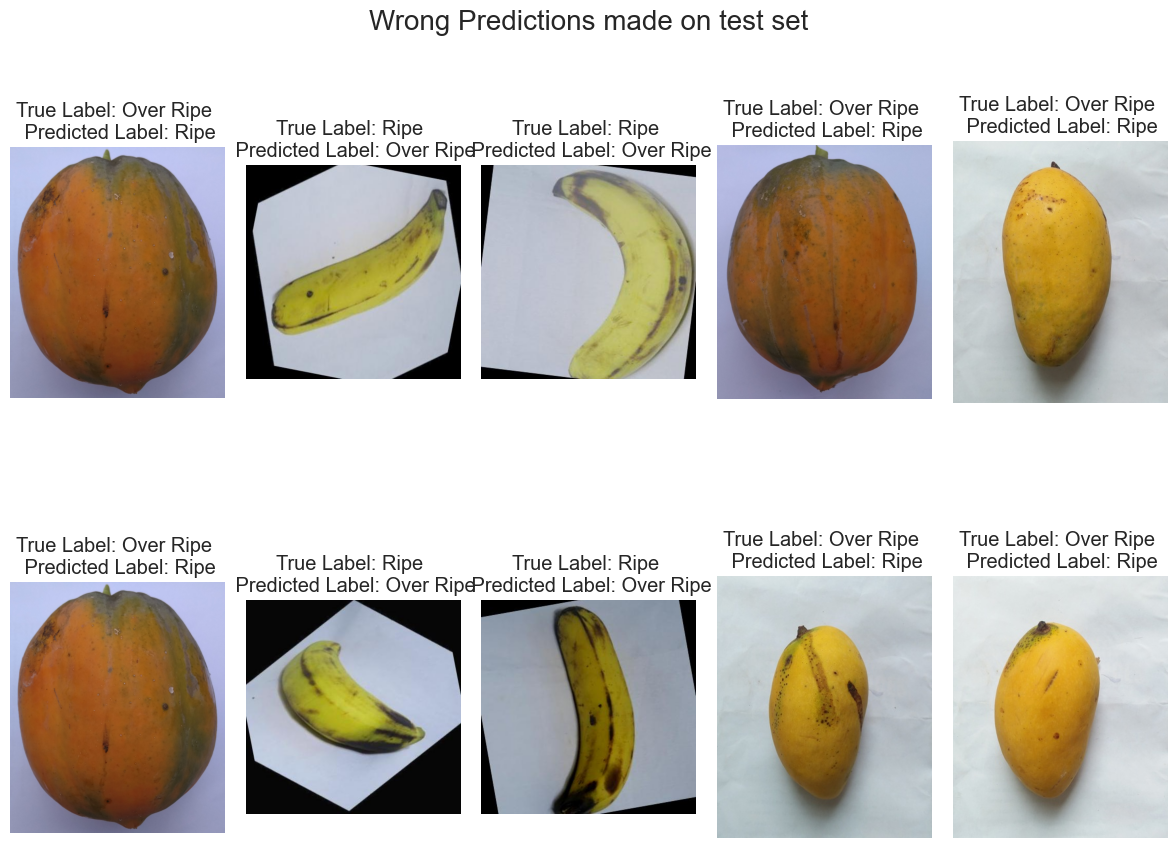

In [73]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()